## 3.2 线性回归从0开始实现

In [1]:
from IPython import display
from matplotlib import pyplot as plt
import keras
import keras.backend as K
import keras.layers as KL
import numpy as np
import random

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

### 3.2.1 生成数据集
y = Xw + b + e

其中:
* X 输入个数（特征数）为 2
* 真实权重w为[2, -3.4], 偏置b为为4.2
* e是均值0，标准差为0.01的正太分布噪音，干扰项

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = np.random.normal(scale=1, size=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += np.random.normal(scale=0.01, size=labels.shape)

In [3]:
features[0], labels[0]

(array([-0.46776423,  1.20065477]), -0.8253907273179022)

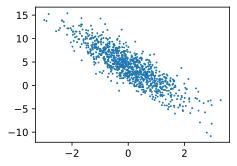

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1], labels, 1);  # 加分号只显示图

### 3.2.2 读取数据

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = np.array(indices[i: min(i + batch_size, num_examples)])
        yield features[j], labels[j]  # take函数根据索引返回对应元素
        

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break
    

[[-0.91104429 -1.70227934]
 [-0.12370813  0.35825442]
 [ 0.36946339 -0.61385628]
 [ 0.44806107 -0.34615031]
 [-1.39270065  0.17088507]
 [-0.11866854  0.35920664]
 [ 0.36260553 -0.19129627]
 [-0.64318649 -1.93857841]
 [-0.31968068 -0.18315006]
 [-0.6872621   0.64458587]] [8.18680763 2.71561304 7.01041566 6.27706561 0.84936497 2.7553199
 5.59186749 9.49830926 4.19691584 0.62678666]


### 3.2.3 初始化模型参数
### 3.2.4 定义模型

In [7]:
model = keras.models.Sequential([
    KL.Dense(1, input_shape=(2,), use_bias=True, 
             kernel_initializer=keras.initializers.random_normal(stddev=0.01),
             bias_initializer=keras.initializers.zeros())
])

W0922 11:26:18.571257 4491531712 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 11:26:18.587435 4491531712 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 11:26:18.596076 4491531712 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



### 3.2.5 定义损失函数

In [8]:
def squared_loss(y_true, y_pred):
    return K.square(y_pred - y_true) / 2

### 3.2.6 定义优化算法

In [9]:
class sgd(keras.optimizers.Optimizer):
    def __init__(self, lr=0.03, **kwargs):
        super(sgd, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        
        for p, g in zip(params, grads):
            new_p = p - self.lr * g
            self.updates.append(K.update(p, new_p))
        return self.updates
        

### 3.2.7 训练模型

In [10]:
model.compile(optimizer=sgd(lr=0.03), loss=squared_loss)
model.fit(features, labels, batch_size, 3)

W0922 11:26:18.640341 4491531712 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0922 11:26:18.740340 4491531712 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0922 11:26:18.743812 4491531712 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/3
1000/1000 [==============================] - 0s 178us/step - loss: 2.8037
Epoch 2/3
1000/1000 [==============================] - 0s 53us/step - loss: 0.0085
Epoch 3/3
1000/1000 [==============================] - 0s 50us/step - loss: 7.4695e-05


In [11]:
print('true_w', true_w)
print('true_b', true_b)
print('model weights', model.get_weights())

true_w [2, -3.4]
true_b 4.2
model weights [array([[ 1.9989384],
       [-3.39913  ]], dtype=float32), array([4.1996193], dtype=float32)]
